In [1]:
from importlib import reload
from astropy import units as u
from astropy import constants as const
from astropy.modeling.models import BlackBody
from astropy.units.equivalencies import spectral

import math

import numpy as np
import matplotlib.pyplot as plt

from scipy.special import expn
from scipy.integrate import simpson

from src import astro530
from src import N_integrator

In [2]:
simpson_wrapper = N_integrator.simpson_wrapper
SvxEn = astro530.SvxEn
eddington_flux = astro530.eddington_flux

In [3]:
myplot_specs = {
    'font.size' : 20
}

plt.rcParams.update(myplot_specs)

In [4]:
# def source_func(t, a0 = 1, a1 = 1, a2 = 1):
#     """ Radiative transfer source function
#     Given τ_ν as a single value or an array, and key word values for a_n where 
#     n < 3, the function will output the source function value. This is viable 
#     up to quadratic form.
    
#     input parameters:
    
#     t [float or array]: values for τ_ν, the optical depth.
#     a0 [float]: Named variable for the zeroth order source term
#     a1 [float]: Named variable for the linear source term
#     a2 [float]: Named variable for the quadratic source term. Set to zero for a 
#                 linear source function.
                
#     output values:
    
#     S_ν [float or array]: outputs the value(s) for the source function. 
    
#     """
#     return a0+a1*t+a2*t**2

# def SvxEn(tval, tau = 0, n=2, src_func = source_func, **kwargs):
#     S = src_func(tval, **kwargs)
    
#     if n == 1 and abs(tval-tau) == 0: return S*229.7  # E1(1e-100)
    
#     En = expn(n,abs(tval-tau))
    
#     return S*En

# def eddington_flux(t_arr, tmin = 0, tmax = 1e2, n_size = 1e-5, src_func = source_func, 
#                        int_wrapper=simpson_wrapper, **kwargs):
#     """ Eddington Flux H_ν(t)
#     Given an array of τ_ν, an optional function variable and keywords for said 
#     function, this function will output the eddington flux at zero optical 
#     depth as calculated using numerical integration with scipy.integrate.simpson  
    
#     input parameters:
    
#     t_arr [array-like]: values for optical depth from 0 to infinity.
#     src_dunc [function]: name of the source function's function which is given 
#                          at least optical depth values in array form. 
#     int_wrapper [function]: name of the integration wrapper function which will 
#                             numerically solve the flux problem. Make sure the 
#                             function's inputs follow the same format as 
#                             N_integrator.simpson_wrapper. 
#     kwargs: keyword arguments for the source function and integrator.
    
#     output values:
    
#     H_ν(0) [float]: Outputs the value for the eddington flux at a τ_ν = 0.
#     """
#     t_arr = np.array([t_arr])
#     src0 = src_func(t_arr[0], **kwargs)
#     src_shape = np.shape(src0)
    
#     if (src0*u.g).unit == u.g:
#         Hv_unit = 1
#     else:
#         Hv_unit = src0.unit * u.sr
        
#     if src_shape[0] == 1:    
#         Hv = np.zeros(len(t_arr))
#         twoD = False
#     else:
#         Hv = np.zeros((src_shape[0],len(t_arr))).T
#         twoD = True
    
#     len_t = len(t_arr)
    
#     for i in range(len_t):
        
#         tv = t_arr[i]
        
#         if tv < 0: raise ValueError("Optical depth cannot be negative. Fix index = "+str(i))
        
#         outward = int_wrapper(tv,tmax,n_size = n_size, scale = "log", function=SvxEn, 
#                                   tau = tv, n = 2, src_func = src_func, **kwargs)
#         inward = -int_wrapper(tmin,tv,n_size = n_size, scale = "log", function=SvxEn, 
#                                       tau = tv, n = 2, src_func=src_func, **kwargs)
#         if twoD:
#             Hv_temp = 1/2*(outward+inward)
#             for j in range(src_shape[0]):
#                 Hv[i,j] = Hv_temp[j]
#         else:
#             Hv[i] = 1/2*(outward+inward)
#         if len_t > 4:
#             if i == 0: print(round(100/len_t,0),"% Done")    
#             if i%int(len_t/4): print("25% Done")
#             if i%int(len_t/2): print("50% Done")
#             if i%int(3*len_t/4): print("75% Done")
            
#     return Hv*Hv_unit

In [5]:
def Planck_tau(t, nu=[10], Teff = 5000*u.K):
    """Planck Function in terms of tau
    Default units are um^-1 for wavenumber and K for effective temperature.
    
    Input Parameters:
        t [array-like]: Array or list of optical depth values or a singlular value
        nu [array-like]: Array or list of wavenumber 
        Teff [float or astropy Quantity]: Value for effective temperature. Default is 5000 K.
    
    Output: B_ν (τ) [erg/s/cm^2/sr/Hz

    """
    
    # Get length of nu and tell if its a single value or list-like
    try:
        len_nu = len(nu)
    except:
        len_nu = 1
        if (nu*u.g).unit == u.g:
            nu = [nu]
        else:
            nu = [nu.value]*nu.unit
        
    try:
        len_t = len(t)
        t_arr = np.array(t)
    except:
        len_t = 1
        t_arr = np.array([t])
        
    if (t_arr[0] * u.g).unit != u.g: 
        raise TypeError("Optical depth, t, must be unitless")
        
    if (nu[0] * u.g).unit == u.g:
        nu_arr = np.array(nu)/u.um
    else:
        nu_arr = np.array(nu)/u.um
        
    if (Teff * u.g).unit == u.g:
        Teff = Teff * u.K
    
    kB = const.k_B
    c = const.c
    h = const.h
    
    T_arr = Teff*(3/4*(t_arr+2/3))**(1/4)
    
    Bv_arr = np.zeros((len_nu,len_t))
    
    for i in range(len_nu):
        nu = nu_arr[i]
        num = 2*h*c*nu**3
        
        for j in range(len_t):
            T=T_arr[j]
            exponent = h*c/kB * nu/T
            
            den = math.exp(exponent)-1  
            if np.isnan((num/den).value):
                Bv_arr[i,j] = 0
            else:
                Bv_arr[i,j] = (num/den).value
            
            if i == 0 and j == 0:
                Bv_unit = (num/den).unit/u.sr
    return (Bv_arr*Bv_unit).to(u.erg/u.s/u.sr/u.cm**2/u.Hz)

In [6]:
#simpson_wrapper(0,100,n_size=1e-3, function=SvxEn,src_func=Planck_tau,nu=1)

In [7]:
eddington_flux([0])

array([0.66666667])

In [8]:
nu=np.logspace(-1,1.2,100)
y_arr = 4*np.pi*eddington_flux(0,n_size = 5e-3,src_func=Planck_tau,nu=np.logspace(-1,1.2,100),Teff=8700*u.K)[0]

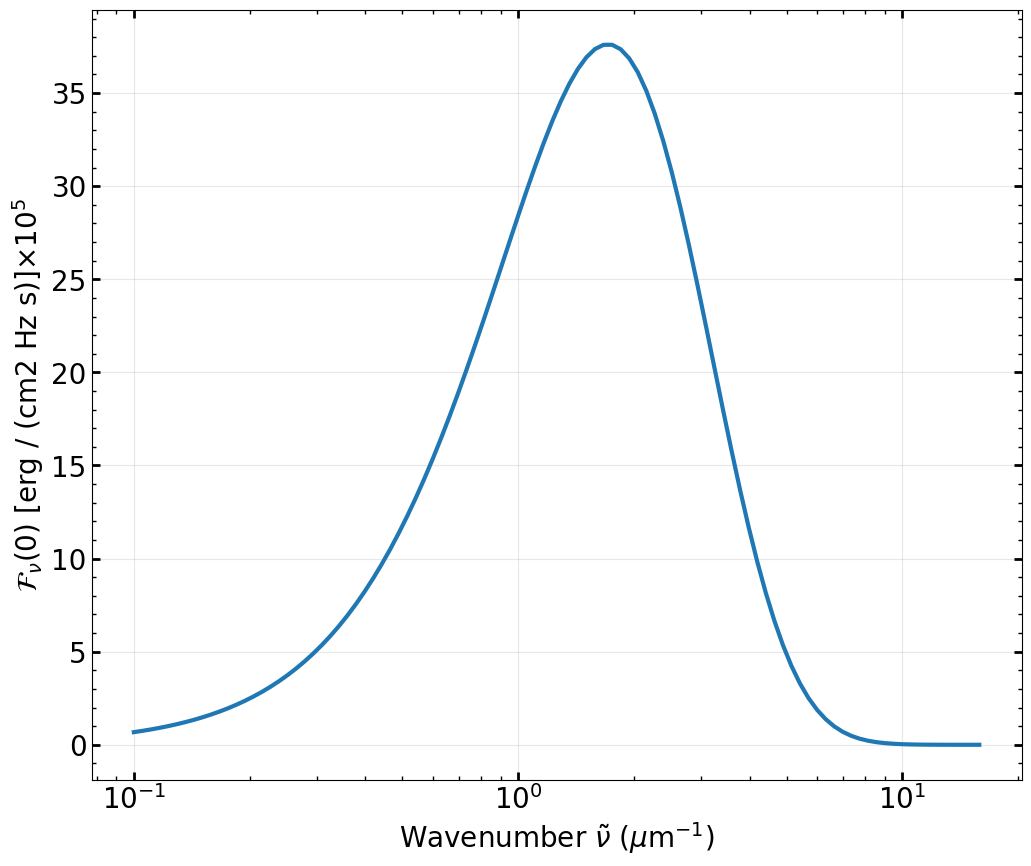

In [9]:
fig, ax = plt.subplots(figsize = (12,10),nrows=1, ncols=1)
    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

output_file = "plots/8b.pdf"

ax.plot(nu,y_arr*1e5, label="Total Emergent Flux",lw=3)
#ax.plot(nu,EB_approx, label="EB Approx.",lw=3)

ax.set_xlabel(r"Wavenumber $\tilde{\nu}~(\mu$m$^{-1})$")
ax.set_ylabel(r"$\mathcal{F}_\nu(0)~[$"+str(y_arr.unit)+r"]$\times 10^{5}$")
ax.set_xscale("log")
#ax.set_title(title)

#ax.legend()

fig.savefig(output_file,bbox_inches='tight')

In [10]:
EB_approx = np.pi*Planck_tau(2/3,nu=nu,Teff=8700*u.K)[:,0]*u.sr

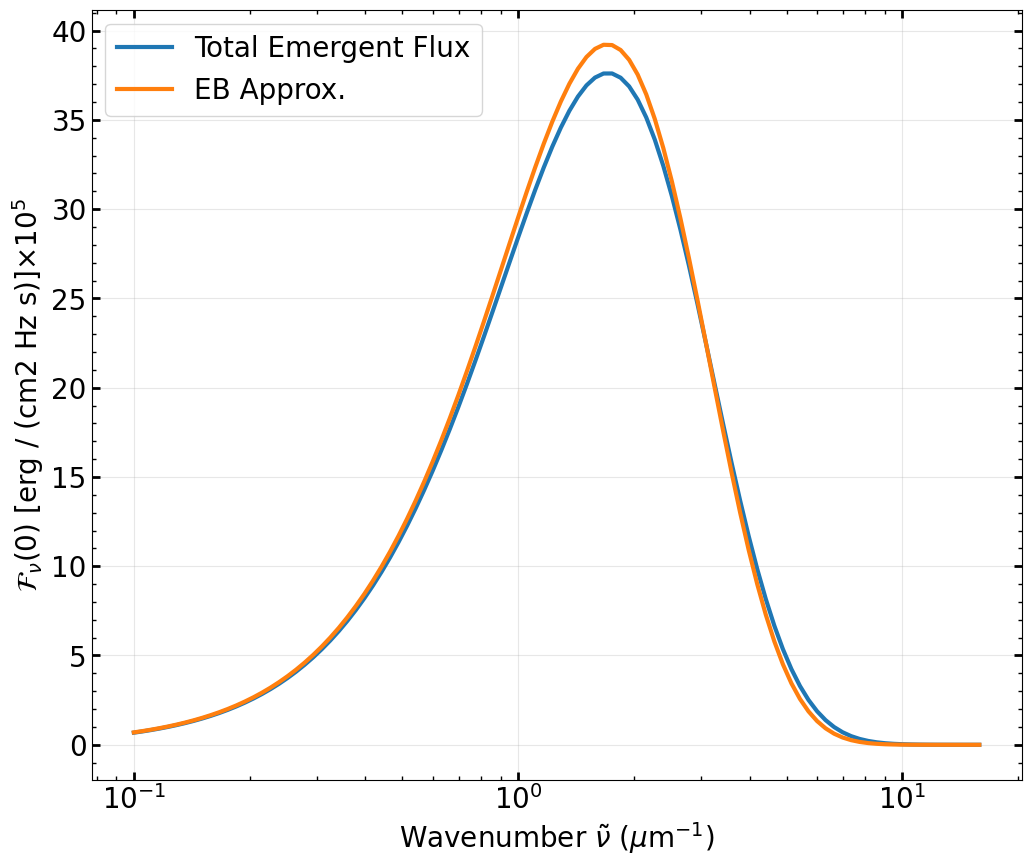

In [11]:
fig, ax = plt.subplots(figsize = (12,10),nrows=1, ncols=1)
    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

output_file = "plots/8d.pdf"

ax.plot(nu,y_arr*1e5, label="Total Emergent Flux",lw=3)
ax.plot(nu,EB_approx*1e5, label="EB Approx.",lw=3)

ax.set_xlabel(r"Wavenumber $\tilde{\nu}~(\mu$m$^{-1})$")
ax.set_ylabel(r"$\mathcal{F}_\nu(0)~[$"+str(y_arr.unit)+r"]$\times 10^{5}$")
ax.set_xscale("log")
#ax.set_title(title)

ax.legend()

fig.savefig(output_file,bbox_inches='tight')

In [12]:
# nu = np.logspace(-1,1.2,100)

# y_arr = 4*np.pi*eddington_flux(0,tmin=0,tmax=100,n_size = 1e-2,src_func=Planck_tau,nu=nu,Teff=8700*u.K)[0]
# EB_approx = np.pi*Planck_tau(2/3,nu=nu,Teff=8700*u.K)[:,0]*u.sr

rel_error = abs(y_arr-EB_approx)/EB_approx

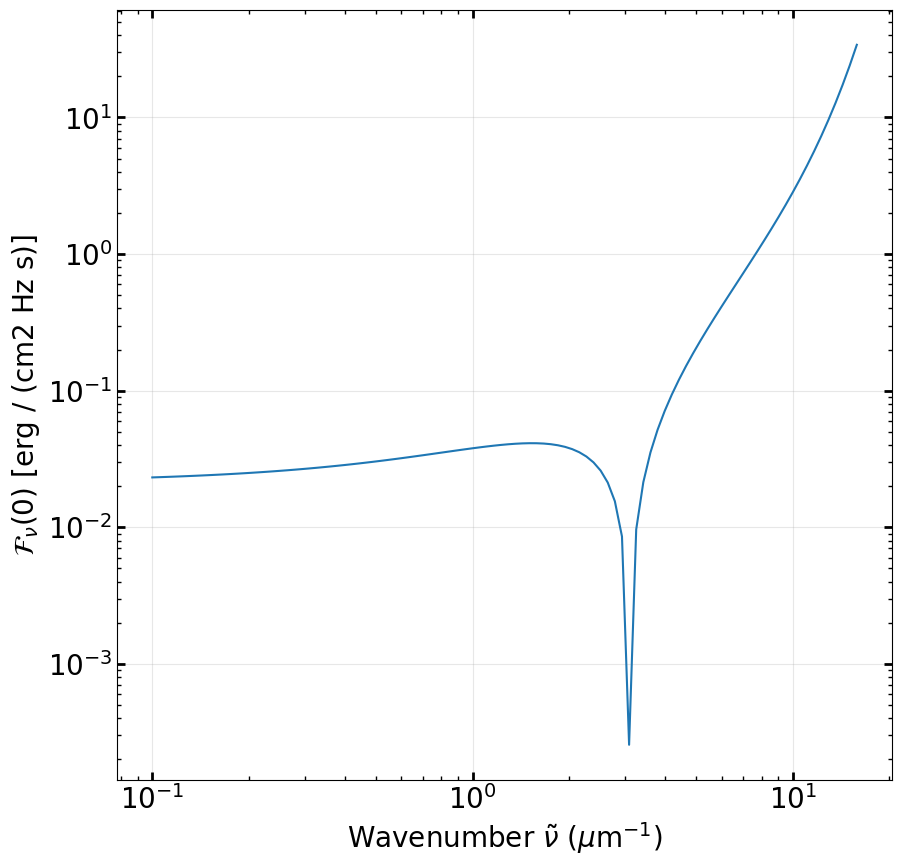

In [13]:
fig, ax = plt.subplots(figsize = (10,10),nrows=1, ncols=1)
    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

output_file = "plots/8b.pdf"

ax.plot(nu,rel_error)

ax.set_xlabel(r"Wavenumber $\tilde{\nu}~(\mu$m$^{-1})$")
ax.set_ylabel(r"$\mathcal{F}_\nu(0)~[$"+str(y_arr.unit)+"]")
ax.set_xscale("log")
ax.set_yscale("log")
#ax.set_title(title)

#ax.legend()

#fig.savefig(output_file,bbox_inches='tight')

In [14]:
def sec_der_src(tau,dt = 1e-6,src_func = Planck_tau, **kwargs):
    tau_arr = np.array([tau-dt,tau,tau+dt])
    src_arr = src_func(tau_arr,**kwargs)
    #dS_dt = [src_arr[:,1]-src_arr[:0],src_arr[:,2]-src_arr[:1]]
    return (1/dt)**2 * (src_arr[:,2]-2*src_arr[:,1]+src_arr[:,0])

In [15]:
def find_val(y_list,val = 0,x_list = None):
    """
    Output index where the list/array is closest to the value
    """
    
    dx = abs(y_list[0] - val)
    index = 0
    
    for i,y in enumerate(y_list):
        dx_i = abs(y-val)
        if dx_i < dx:
            dx = dx_i
            index = i
    
    print("y-value: "+str(y_list[index]))
    
    if x_list is not None:
        print("x-value: "+str(x_list[index]))
        
    if val != 0:
        print("Relative Error = "+str(abs(dx/val)))
    else:
        print("Offset Error = "+str(abs(dx)))
    
    return index

In [16]:
n_steps = 1000
#nu_b=np.logspace(-1,1.2,n_steps)
nu_b = np.linspace(0,13,n_steps)

lbl = int(0.1*n_steps)
ubl = -int(0.1*n_steps)

sec_arr = sec_der_src(1,nu=nu_b,dt=1e-3,Teff=8700*u.K)

ind0 = find_val(sec_arr[lbl:ubl],val = 0,x_list = nu_b[lbl:ubl])
sec_der_0 = sec_arr[ind0]

offset = -10**5*(y_arr - EB_approx)

/Users/kdn5172/anaconda3/lib/python3.11/site-packages/astropy/units/quantity.py:611: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


y-value: -2.6120381899086276e-08 erg / (cm2 Hz s sr)
x-value: 3.149149149149149
Offset Error = 2.6120381899086276e-08 erg / (cm2 Hz s sr)


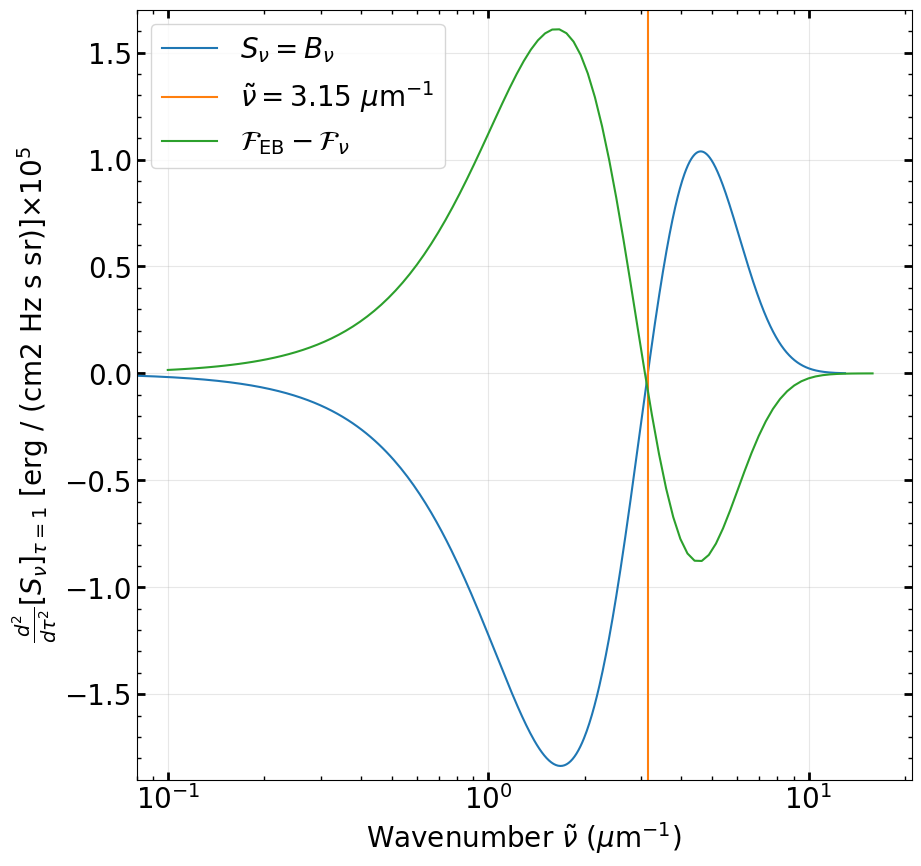

In [17]:
fig, ax = plt.subplots(figsize = (10,10),nrows=1, ncols=1)
    
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.minorticks_on()
ax.grid(True,alpha=.3)

ax.tick_params(direction='in', axis='both',which='minor',length=3,width=1)#,labelsize=8)
ax.tick_params(direction='in',axis='both',which='major',length=6,width=2)#,labelsize=8)

ax.plot(nu_b,sec_arr*10**5,label=r"$S_\nu = B_\nu$")
ax.plot([(nu_b[lbl:ubl])[ind0],(nu_b[lbl:ubl])[ind0]],[-2,2],label=r"$\tilde{\nu}=$"+str(round((nu_b[lbl:ubl])[ind0],2))+r"$~\mu$m$^{-1}$")
ax.plot(nu,offset,label=r"$\mathcal{F}_{\mathrm{EB}} - \mathcal{F}_\nu$")

ax.set_xlim([0.08,21])
ax.set_ylim([-1.9,1.7])

ax.set_xlabel(r"Wavenumber $\tilde{\nu}~(\mu$m$^{-1})$")
ax.set_ylabel(r"$\frac{d^2}{d\tau^2}[S_\nu]_{\tau=1}~$["+str(sec_arr.unit)+r"]$\times 10^{5}$")
ax.set_xscale("log")
#ax.set_yscale("log")
#ax.set_title(title)

ax.legend()

output_file = "plots/8e.pdf"

fig.savefig(output_file,bbox_inches='tight')